In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 305633328


In [3]:
# define the plotting parameters

figsize = (8,4)

In [8]:
# import the data

# choose a TIC ID to analyze
ticid = 305633328

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lcc_tess = sr.download_all() 
lc_tess = lcc_tess.stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 15,2019,QLP,1800,305633328,0.0,N/A
1,TESS Sector 16,2019,SPOC,120,305633328,0.0,G022062
2,TESS Sector 17,2019,SPOC,120,305633328,0.0,G022062
3,TESS Sector 56,2022,SPOC,120,305633328,0.0,G05003
4,TESS Sector 57,2022,SPOC,120,305633328,0.0,G05003


C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\lightkurve\collections.py:213: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(


72175

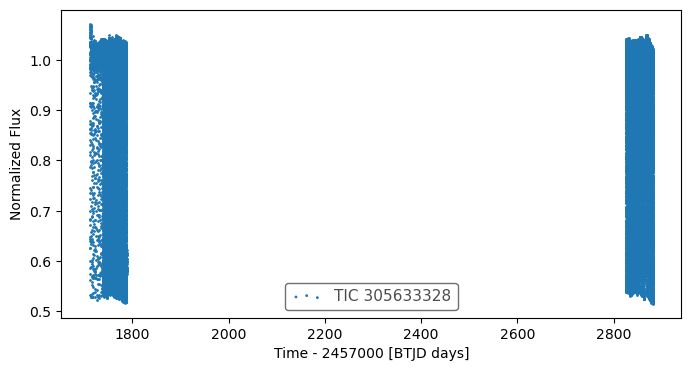

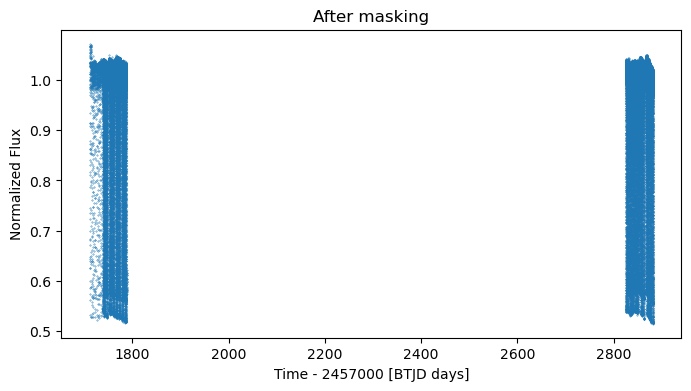

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
# mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

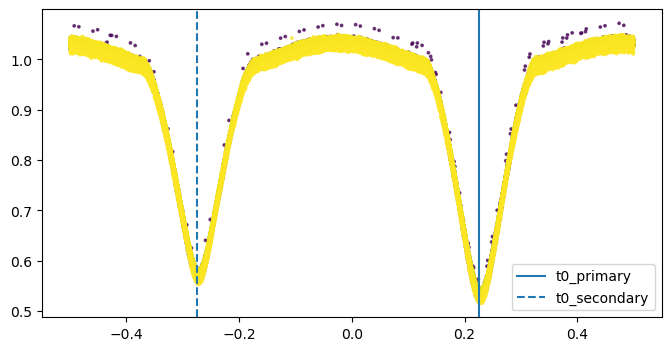

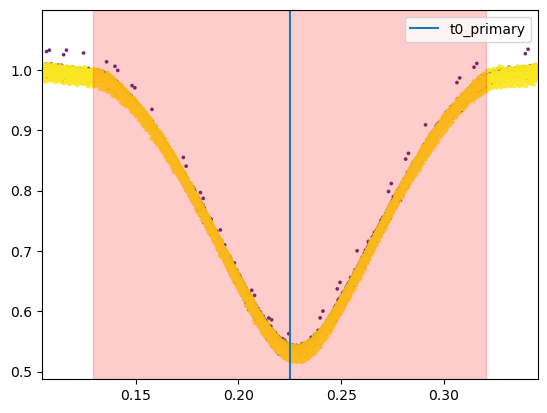

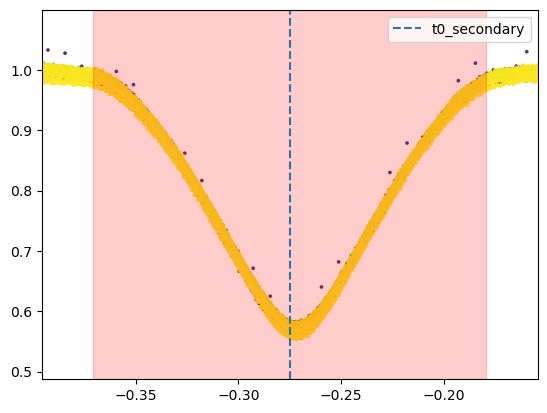

In [16]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1739.1609, duration_hr=3.5098, period=1.251875, label="s0014-s0060:TCE1",
# epoch=1739.3781, duration_hr=4.3976, period=1.251404, label="s0014-s0060:TCE2",
# epoch=1738.8953, duration_hr=2.1556, period=1.253058, label="s0014-s0060:TCE3",
# VSX: 2.5035 
# MCMC on df_primary: 2.503475192592715

# FILL-IN THE eclipse epoch / period, 
period = 2.503475 # MCMC , pretty close to VSX

t0_primary = 1739.1609  + 0.055  # offsets applied after visual inspection
t0_secondary = t0_primary +  period / 2


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 11.5
duration_hr_secondary = 11.5

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
plt.xlim(t1_s - 0.025, t4_s + 0.025);
plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
plt.legend();
# plt.ylim(0.85, None);
plt.show()

### Compare folded plots across sectors

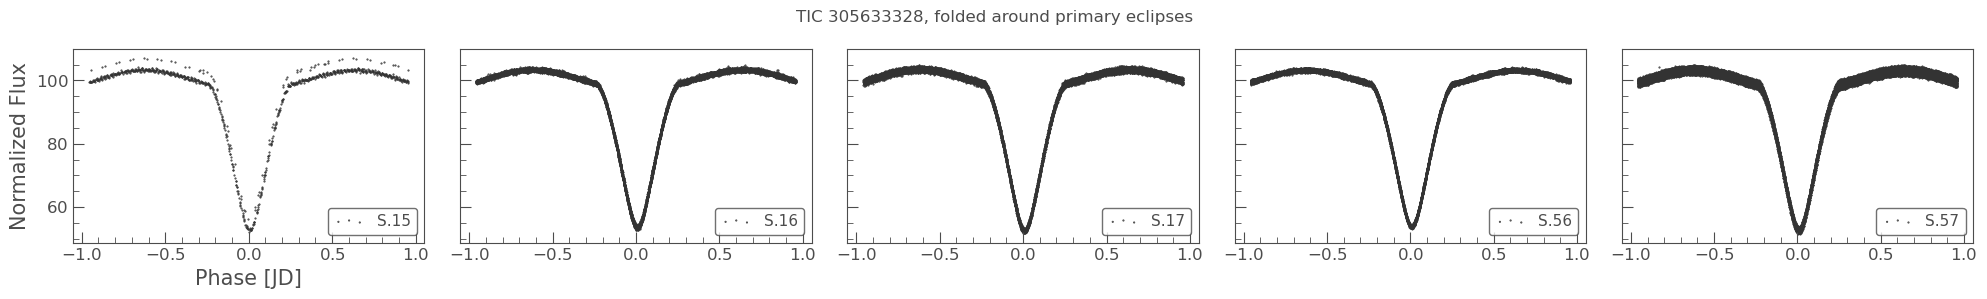

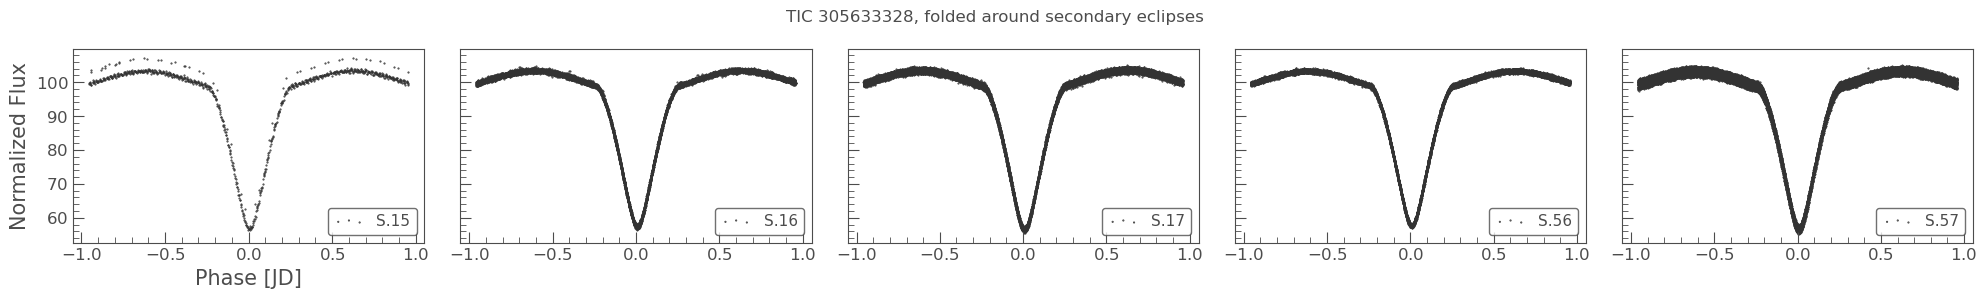

In [9]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

Primary:   1711.6776750000001 0.22500000000001186
window_width_p (phase): 0.229680743766165
Secondary: 1712.9294125000001 -0.27499999999999203
window_width_s (phase): 0.229680743766165


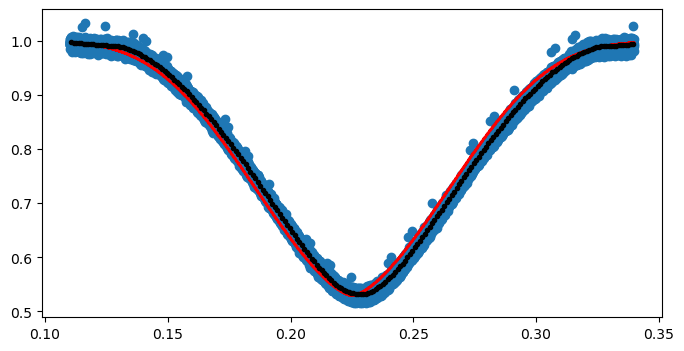

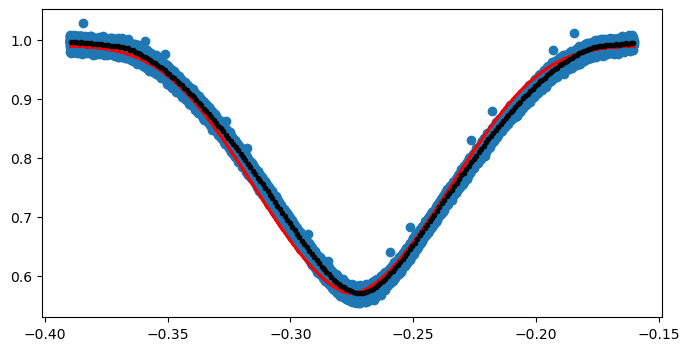

In [19]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.2 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.2 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.00, -0.47, midpoint_p, 0.046, 0.765]
start_vals_s = [0.99, -0.42, midpoint_s, 0.043, 0.85]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
if t0_secondary is not None:
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

In [ ]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()
        
    # MCMC result
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.001380922745853, -0.47346171969855044, 1711.6851669846437, 0.046357664619676595, 0.7655808521926775, 2.503475192592715
    # std_p: 3.528031339461054e-08
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [0.97, -0.46, t0_primary, 0.030, 1.0, period],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=-1,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 5 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:35<00:00, 10.44it/s]


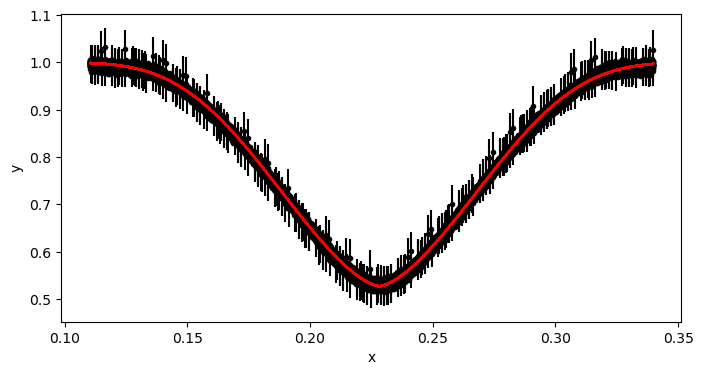

emcee parallel enabled, use 5 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:47<00:00,  9.30it/s]


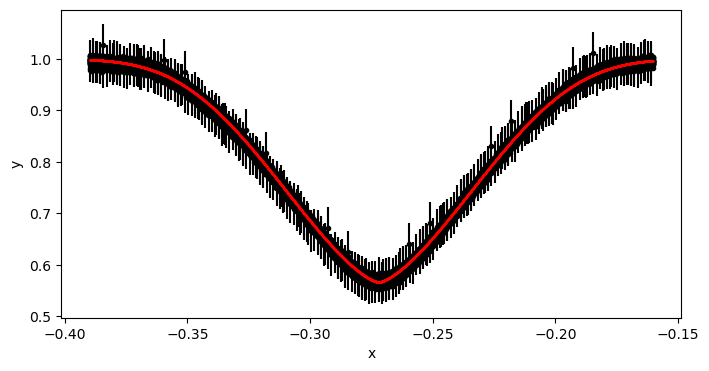

In [20]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, pool=-1, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, pool=-1, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0013935966647938, -0.4734715636907546, 0.22801318967551848, 0.0463582226188052, 0.7656008890455832
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 0.9999842494068141, -0.4337979706742515, -0.27206447118966226, 0.046711643488900646, 0.7236698025608922

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [21]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0013935966647938, -0.4734715636907546, 0.22801318967551848, 0.0463582226188052, 0.7656008890455832
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 0.9999842494068141, -0.4337979706742515, -0.27206447118966226, 0.046711643488900646, 0.7236698025608922


467

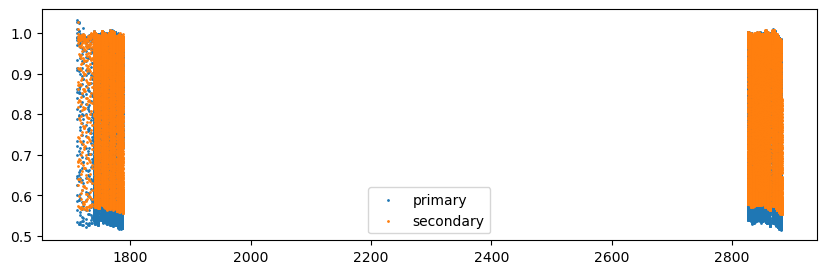

In [22]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1711.6776750000001 2.503475 1711.6776750000001


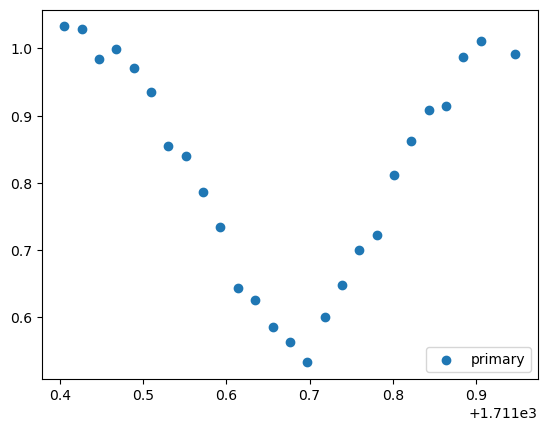

1711.6776750000001 2.503475 1714.1811500000001


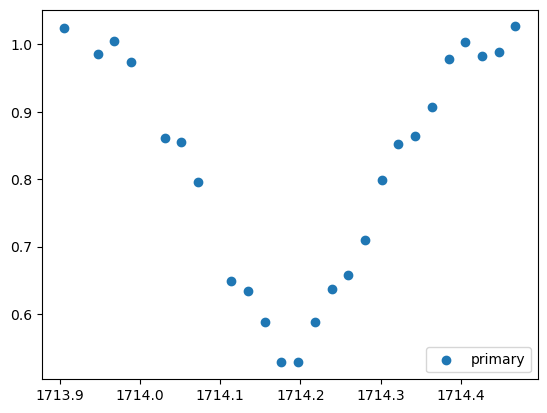

1711.6776750000001 2.503475 1716.684625


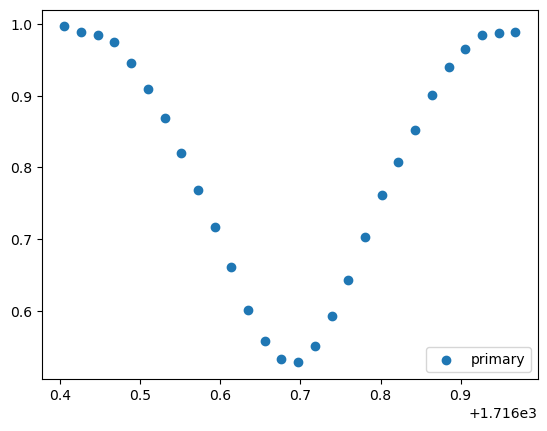

1712.9294125000001 2.503475 1712.9294125000001


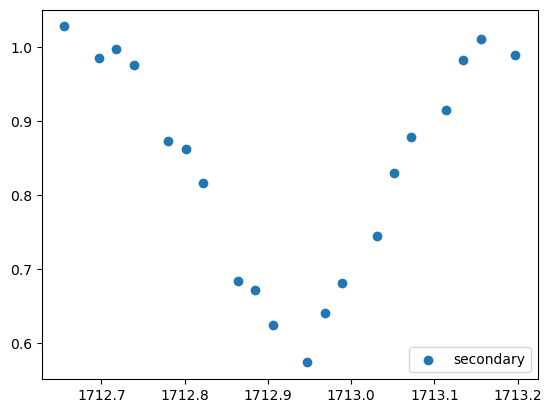

1712.9294125000001 2.503475 1715.4328875


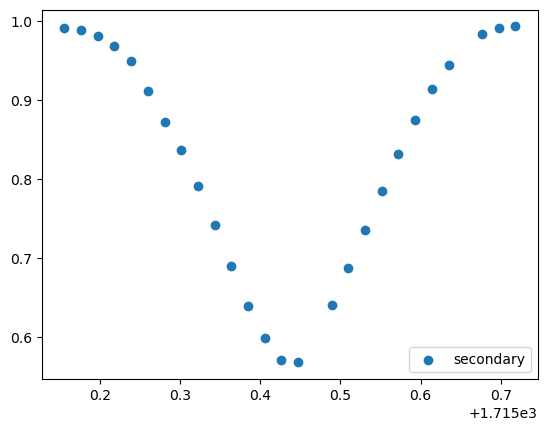

1712.9294125000001 2.503475 1717.9363625


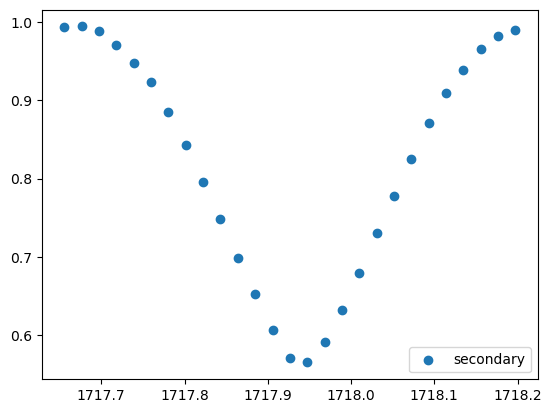

In [23]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
1736.7124250000002 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.28it/s]


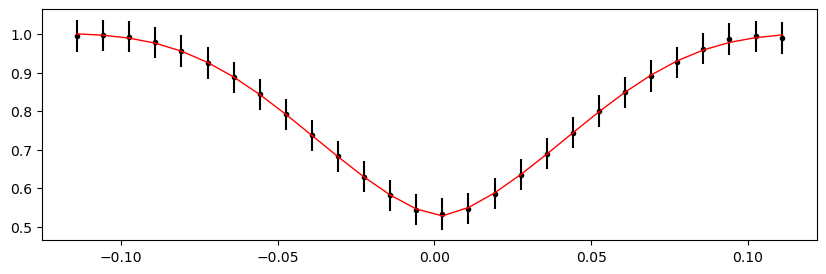

1739.2159000000001 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 256.14it/s]


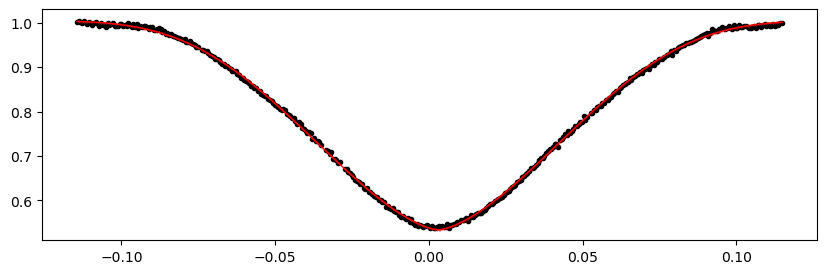

1741.7193750000001 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 238.44it/s]


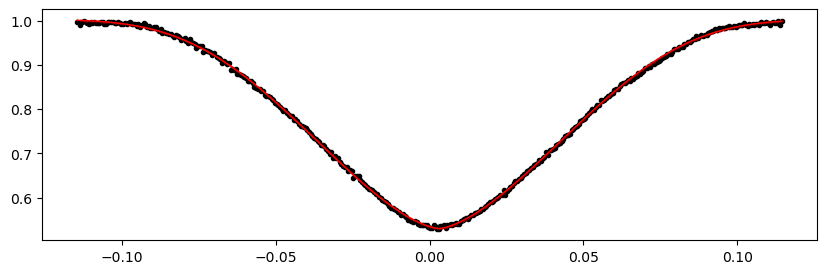

1744.22285 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.41it/s]


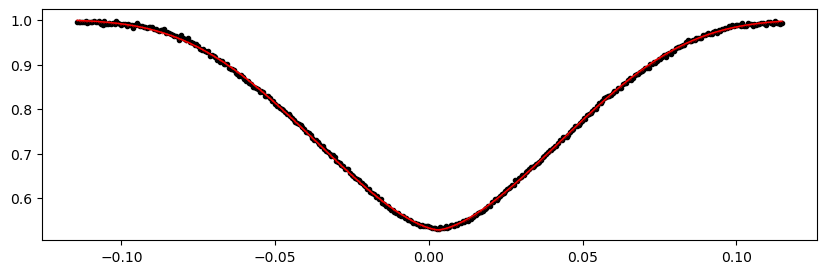

1746.726325 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 262.06it/s]


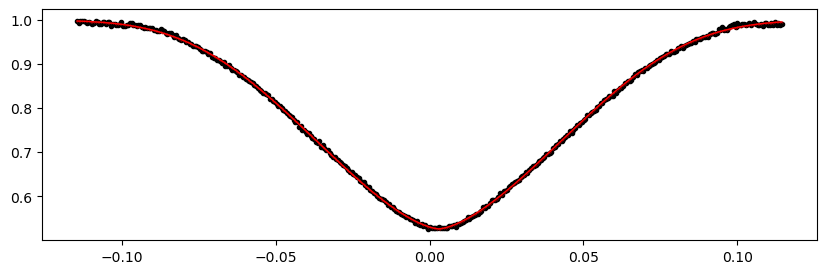

1751.733275 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 310.26it/s]


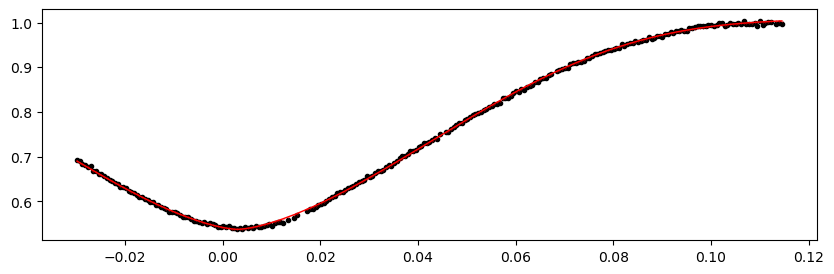

1754.23675 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.69it/s]


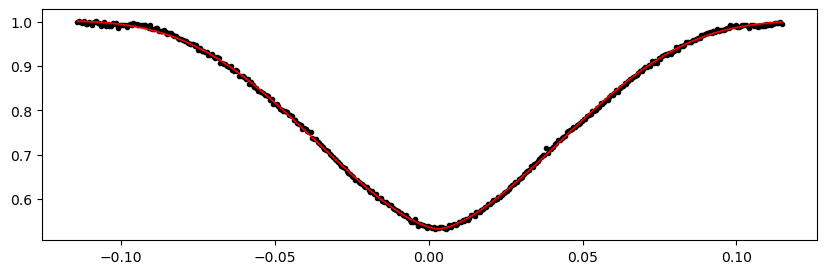

1756.7402250000002 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 242.27it/s]


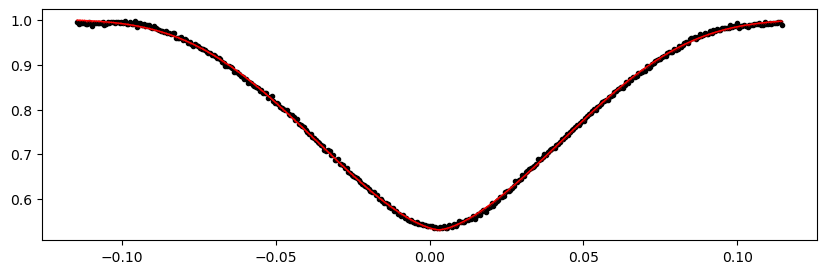

1759.2437000000002 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 258.88it/s]


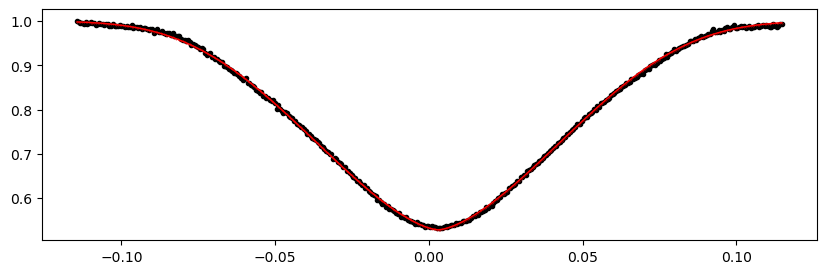

1761.7471750000002 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 256.20it/s]


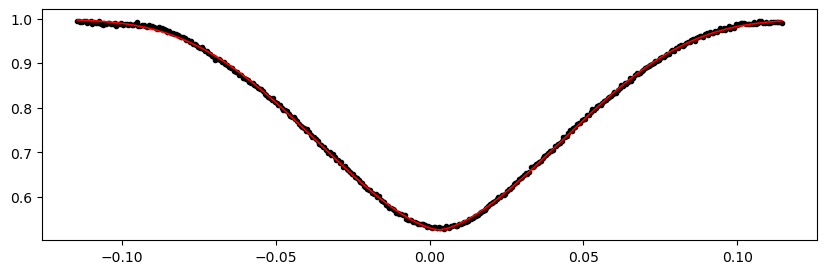

1766.7541250000002 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.46it/s]


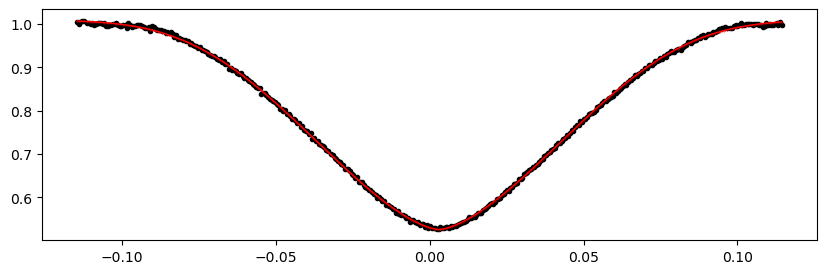

1769.2576000000001 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.16it/s]


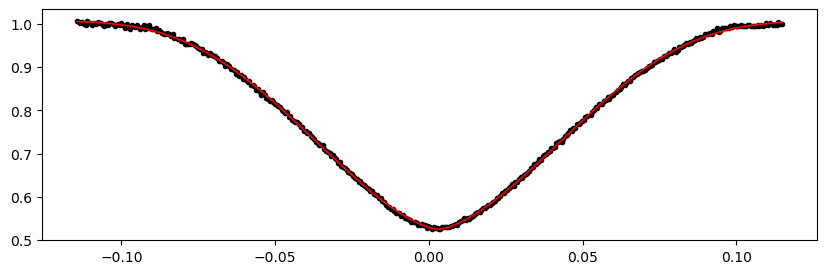

1771.7610750000001 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 258.18it/s]


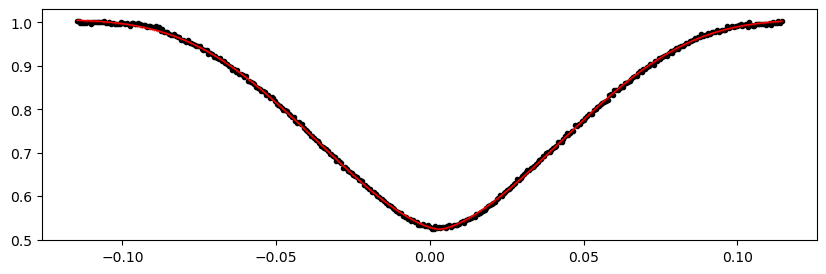

1774.26455 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 263.14it/s]


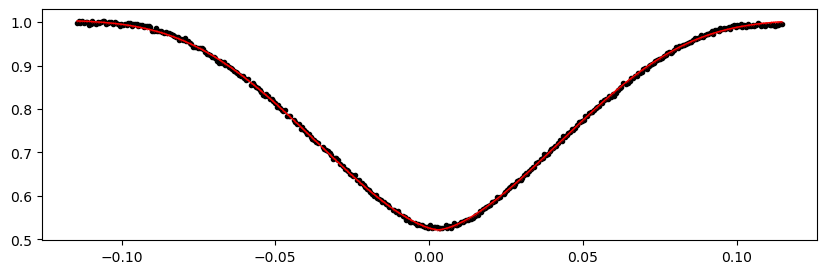

1779.2715 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.61it/s]


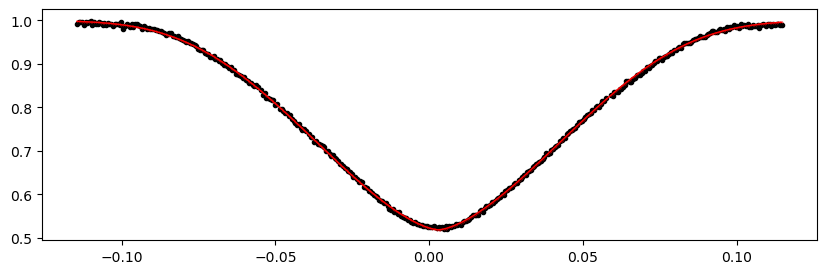

1781.774975 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.22it/s]


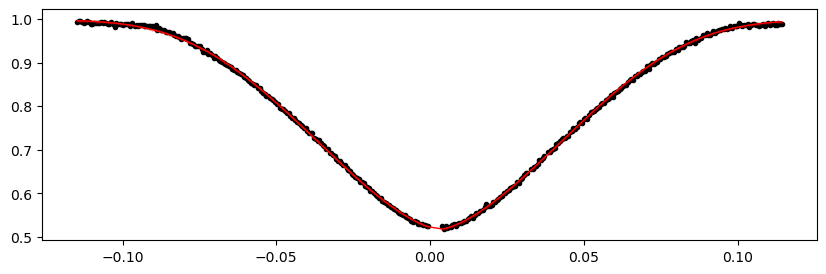

1784.2784500000002 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 262.48it/s]


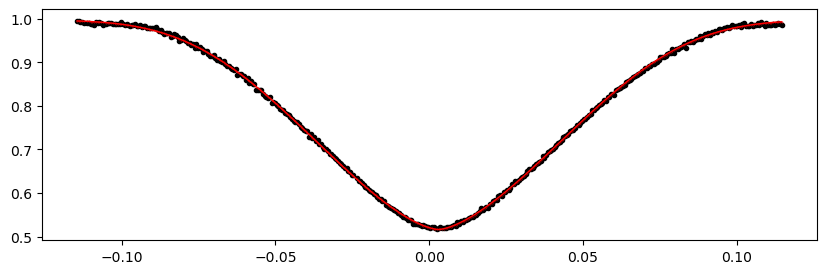

1786.7819250000002 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.22it/s]


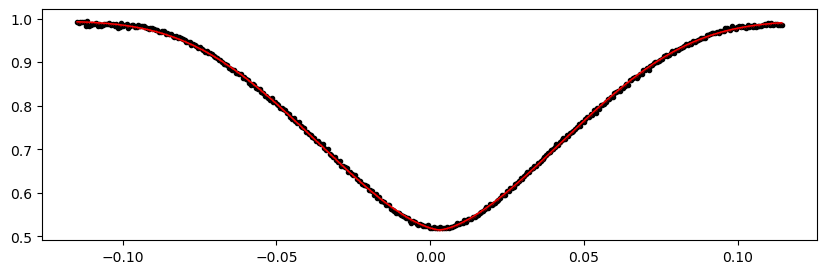

2825.72405 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.86it/s]


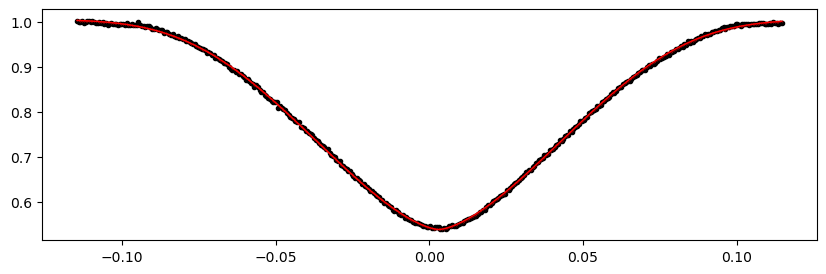

2828.2275250000002 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.68it/s]


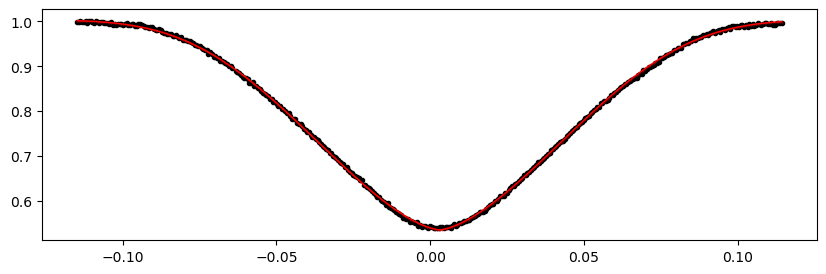

2830.7309999999998 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 245.40it/s]


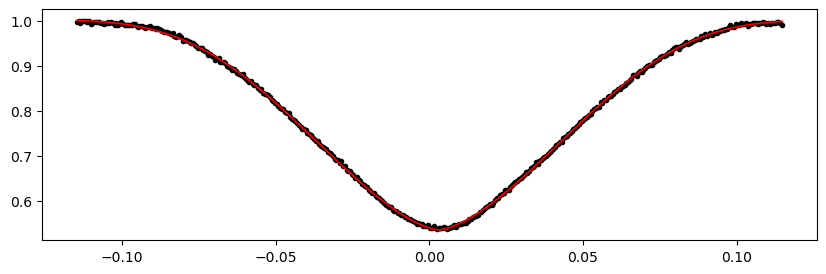

2833.234475 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 262.97it/s]


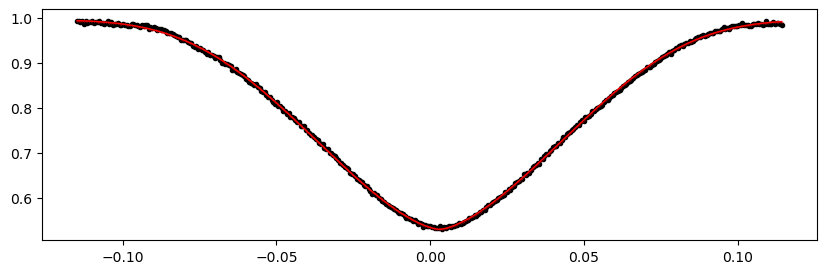

2835.73795 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 255.49it/s]


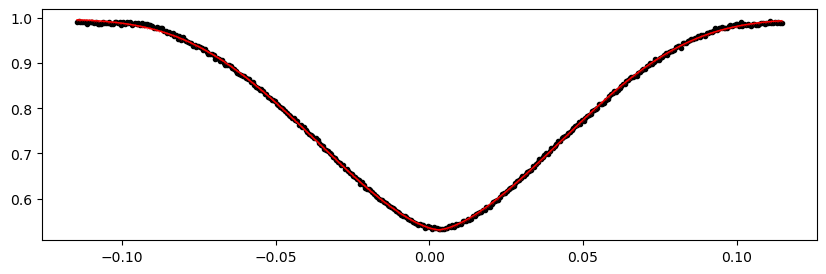

2838.241425 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.01it/s]


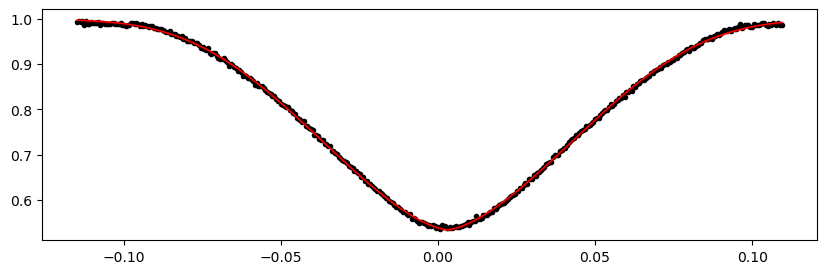

2840.7449 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.41it/s]


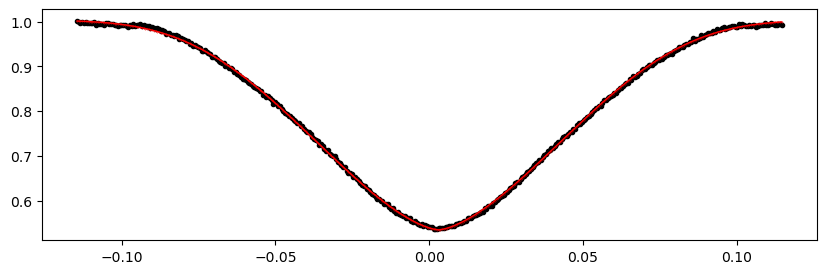

2843.248375 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.69it/s]


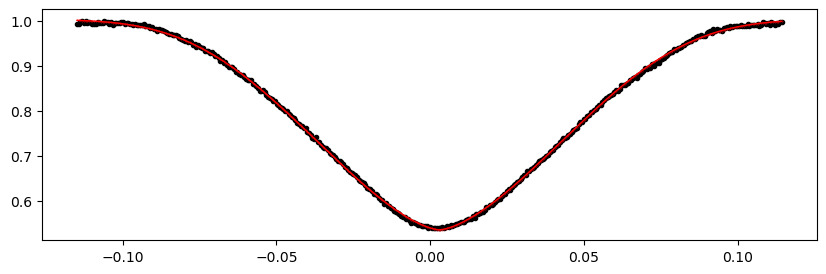

2845.75185 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 294.38it/s]


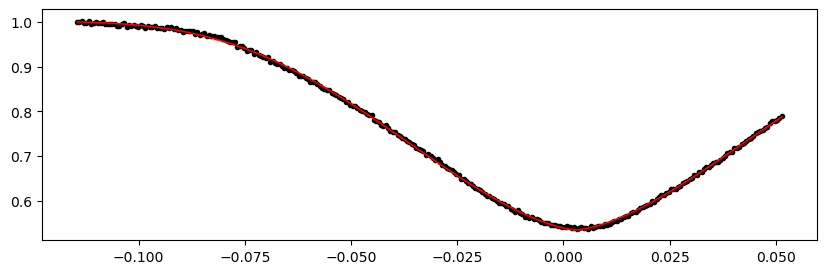

2848.255325 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.46it/s]


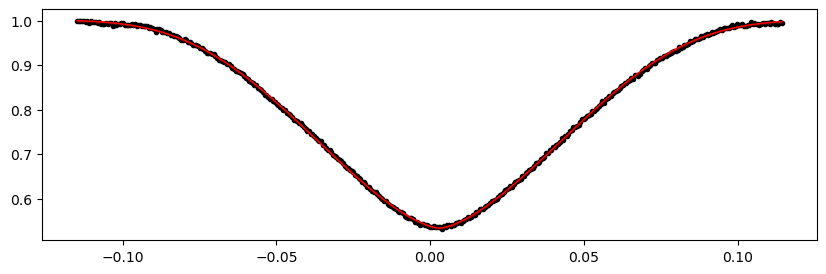

2850.7588 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.71it/s]


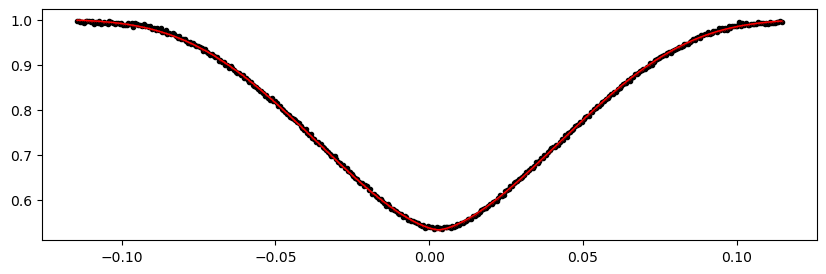

2853.262275 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.26it/s]


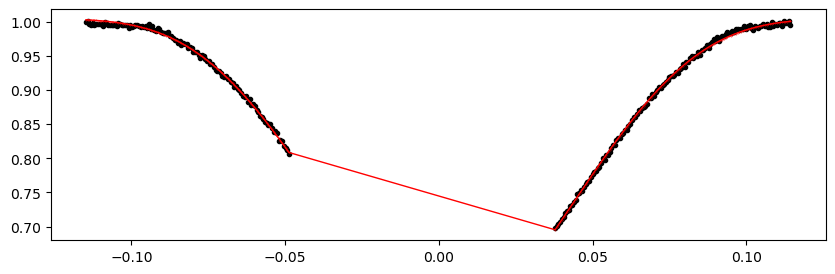

2855.76575 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 258.38it/s]


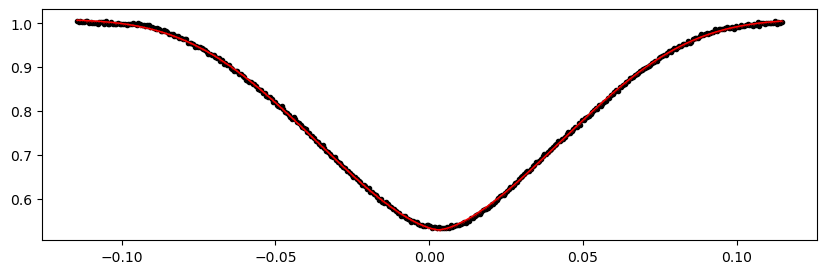

2858.269225 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 257.97it/s]


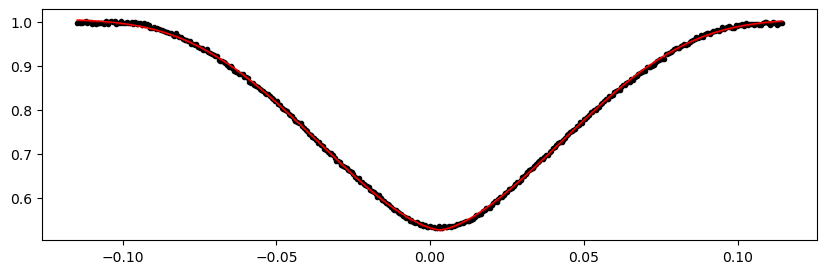

2860.7727 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 277.69it/s]


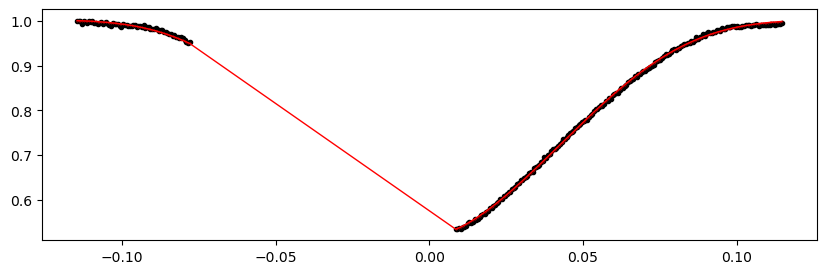

2863.276175 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 273.23it/s]


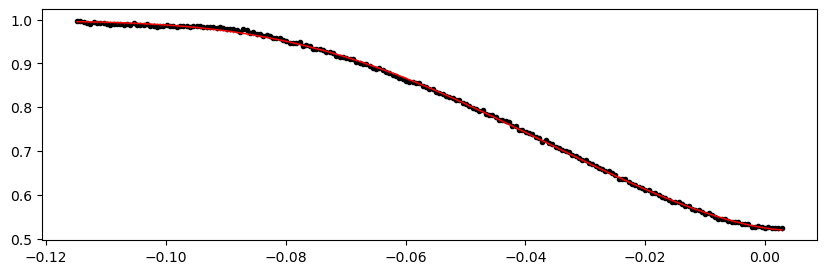

2868.283125 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 240.46it/s]


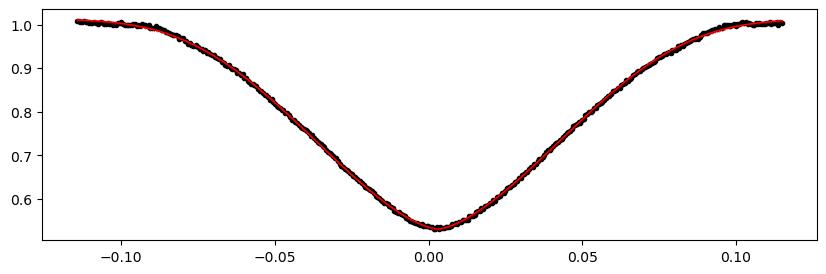

2870.7866000000004 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 253.38it/s]


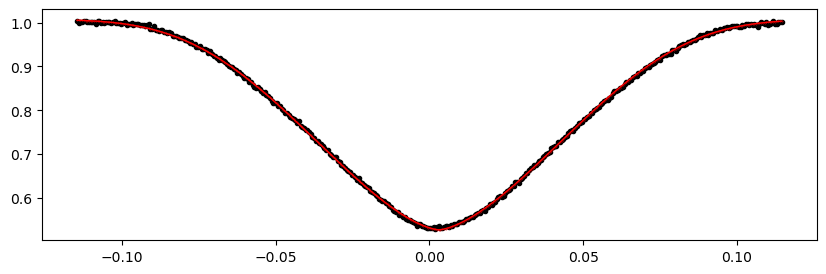

2873.290075 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.18it/s]


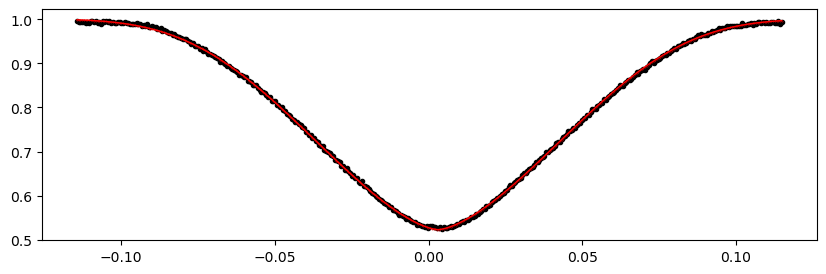

2875.7935500000003 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 255.12it/s]


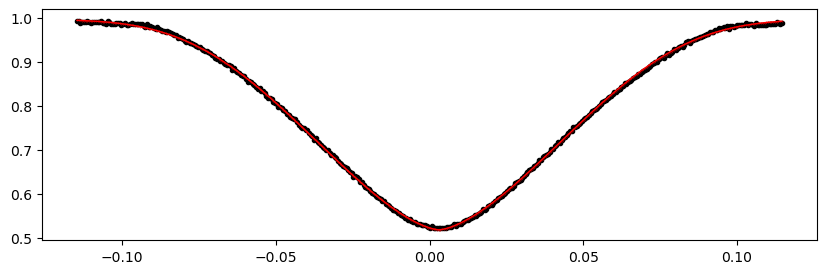

2878.297025 1.0013935966647938 -0.4734715636907546 0.22801318967551848


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.05it/s]


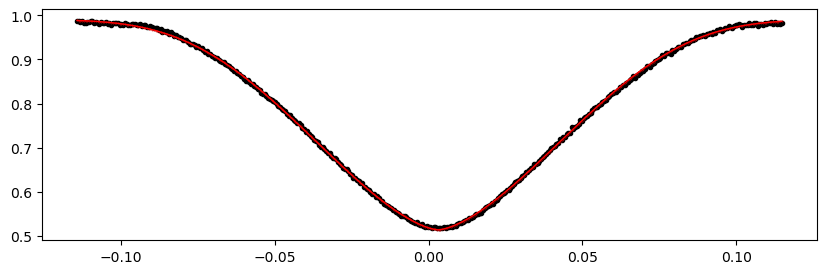

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Time 1712.9294125000001 does not have enough data points: 20
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Number 14 has already been completed -- skip
Number 16 has already been completed -- skip
Number 17 has already been completed -- skip
1757.9919625000002 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.12it/s]


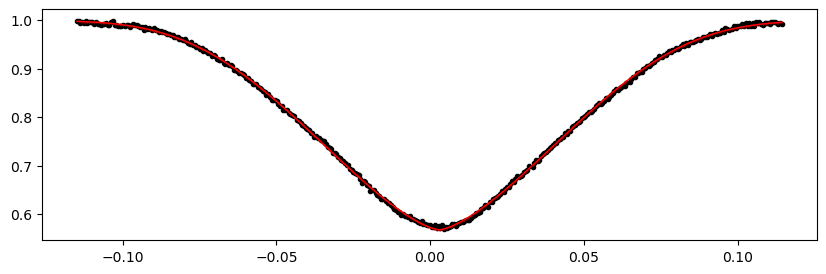

1760.4954375000002 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 245.50it/s]


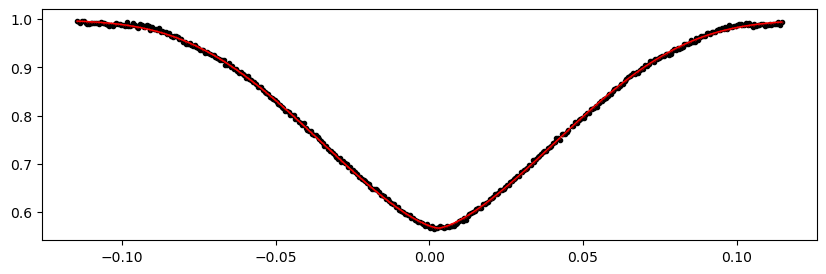

1765.5023875000002 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 254.23it/s]


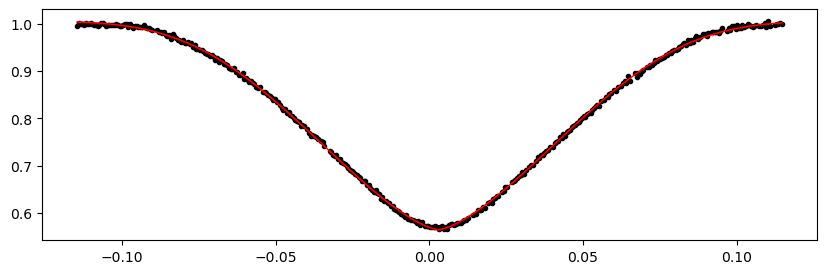

1768.0058625000001 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.64it/s]


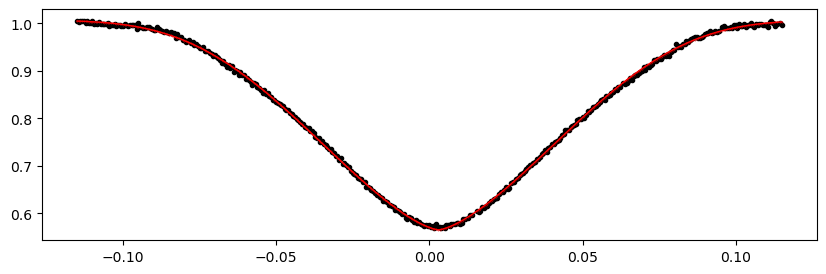

1770.5093375000001 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 266.73it/s]


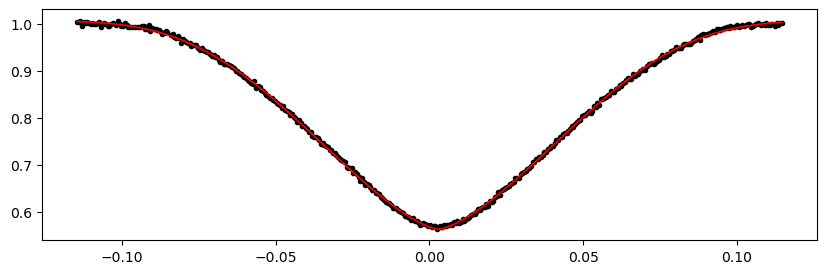

1773.0128125 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.52it/s]


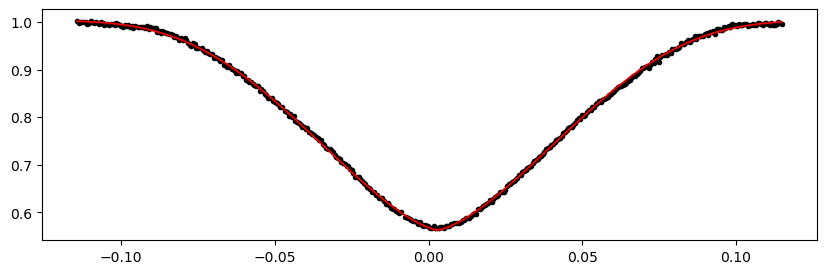

1778.0197625 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 267.92it/s]


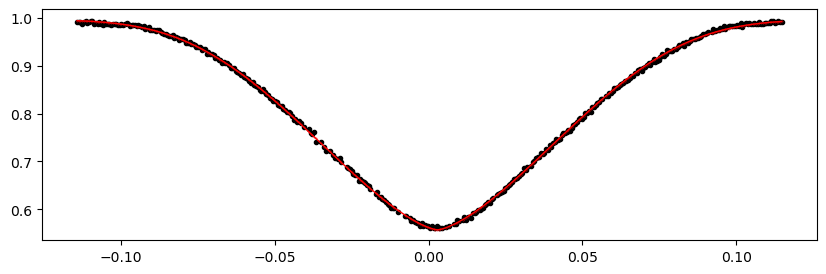

1780.5232375 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 262.19it/s]


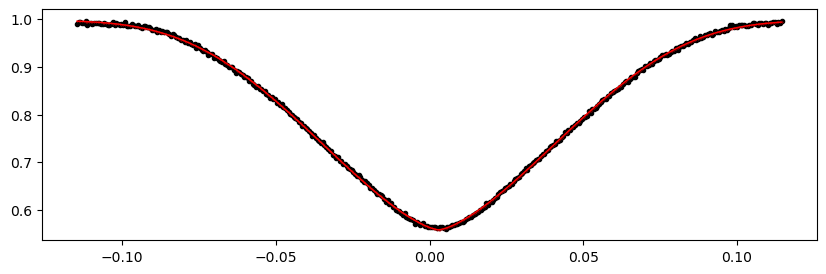

1783.0267125 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 256.49it/s]


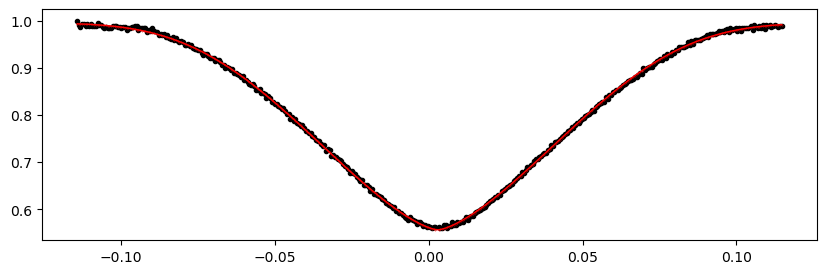

1785.5301875 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.07it/s]


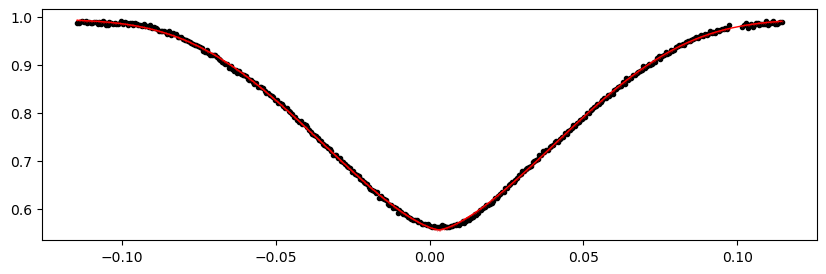

1788.0336625000002 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 291.87it/s]


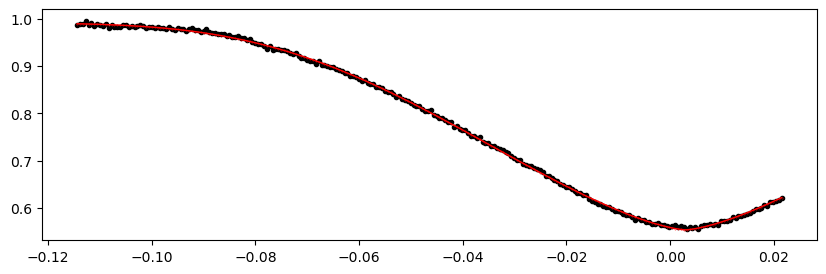

2826.9757875 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.26it/s]


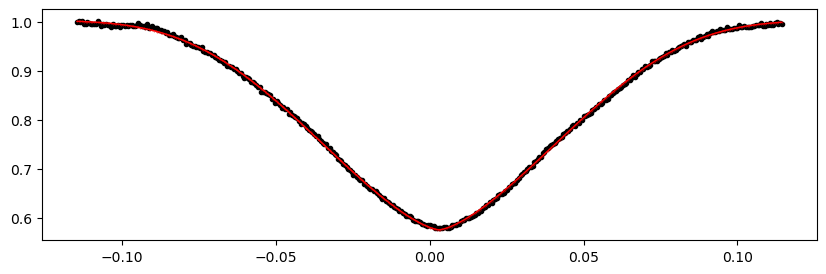

2829.4792625 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.56it/s]


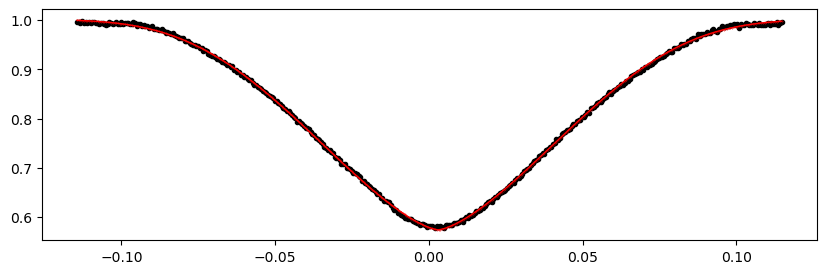

2831.9827375 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.43it/s]


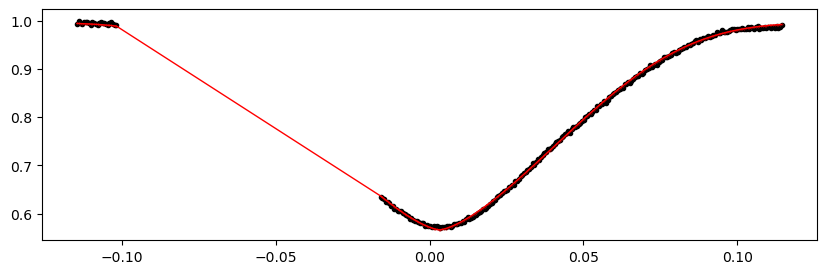

2834.4862125 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 263.83it/s]


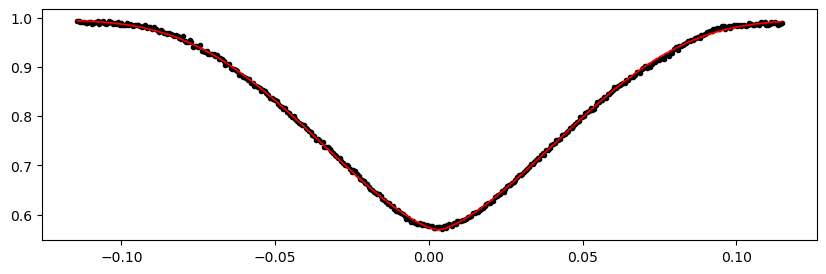

2836.9896875000004 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.24it/s]


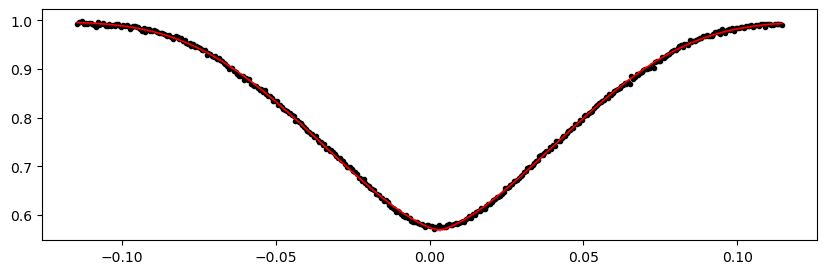

2839.4931625 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 263.17it/s]


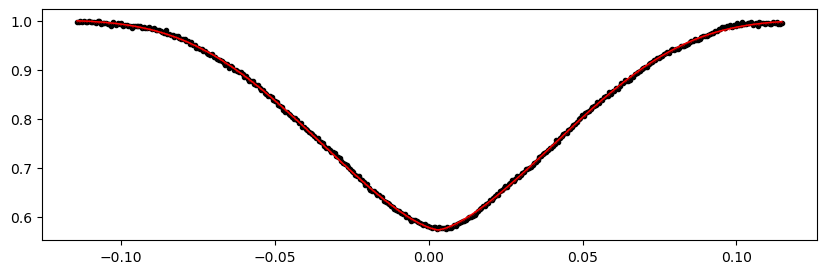

2841.9966375000004 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 261.95it/s]


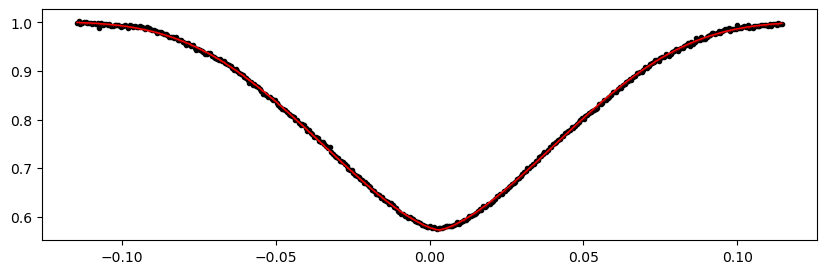

2844.5001125 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.94it/s]


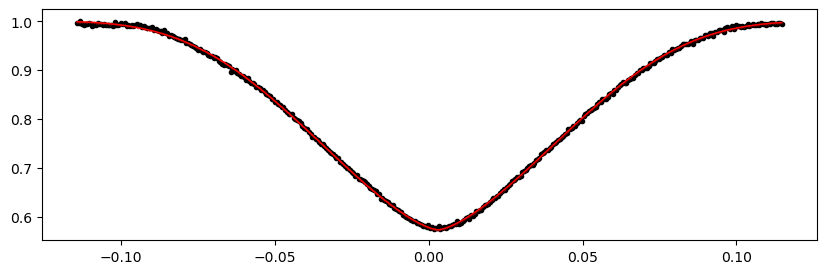

2847.0035875000003 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.81it/s]


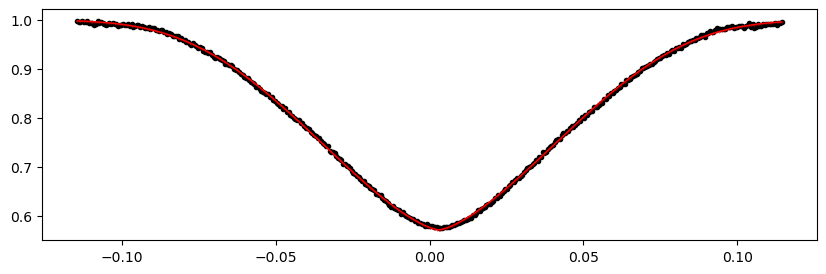

2849.5070625 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.48it/s]


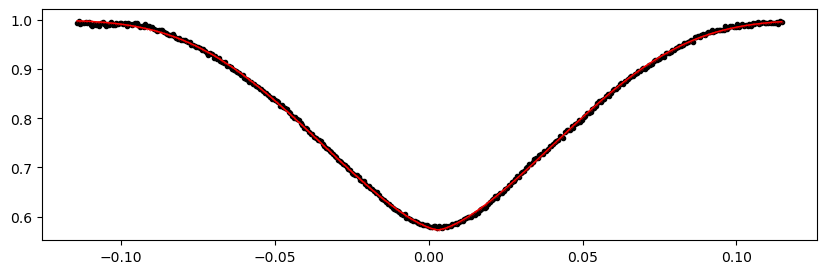

2852.0105375000003 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.33it/s]


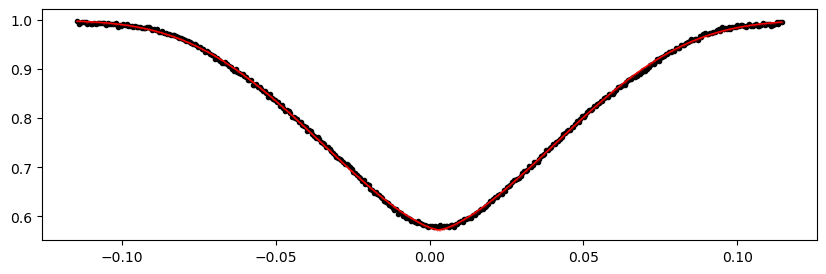

2854.5140125 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.61it/s]


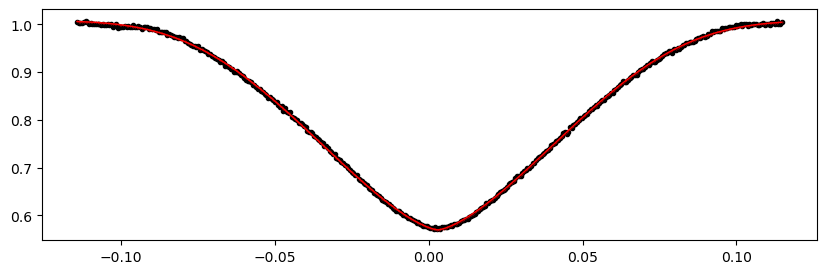

2857.0174875000002 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.24it/s]


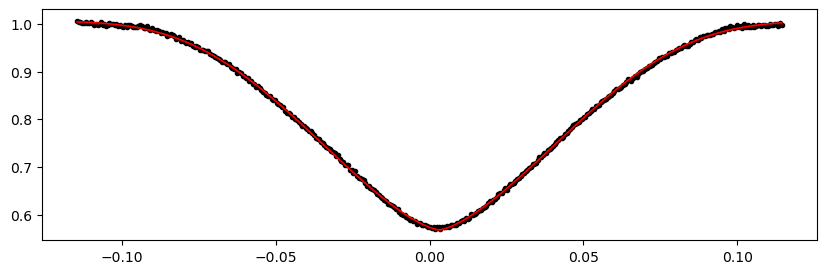

2859.5209624999998 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.52it/s]


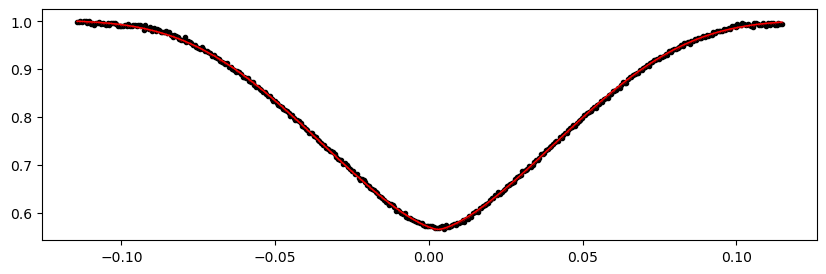

2862.0244375 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.04it/s]


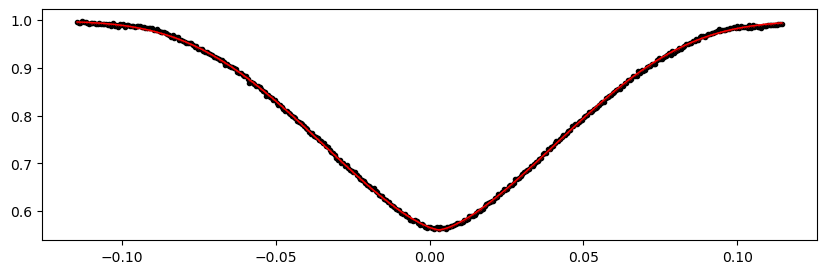

2867.0313875 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 279.31it/s]


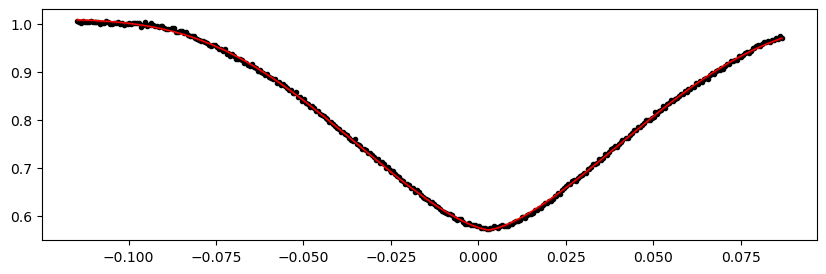

2869.5348625 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.04it/s]


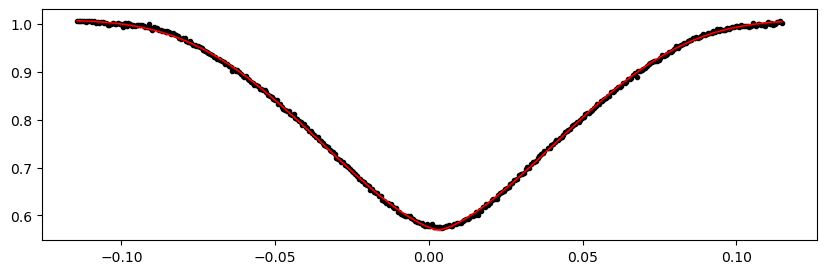

2872.0383375 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.56it/s]


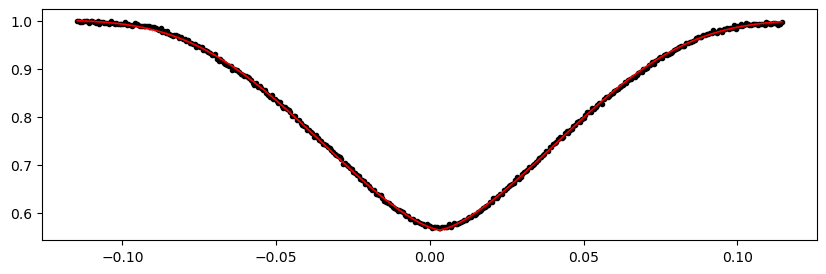

2874.5418125 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 308.22it/s]


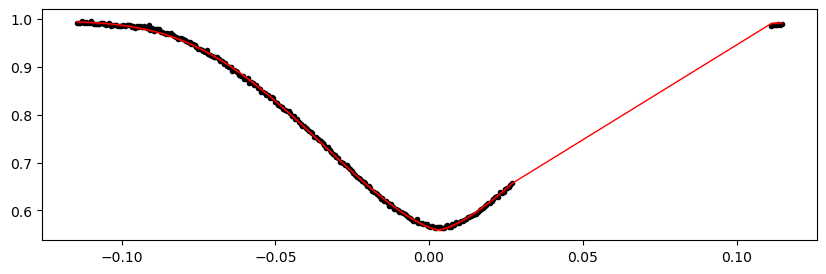

2877.0452875 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 264.27it/s]


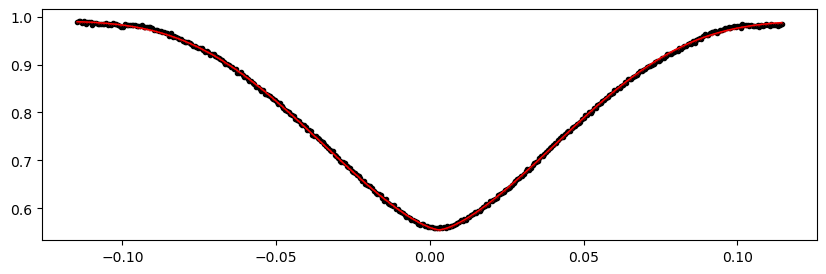

2879.5487625 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 263.92it/s]


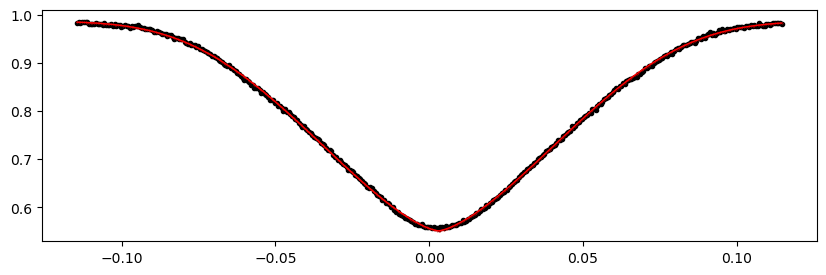

In [27]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=20, 
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=20, 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")


Fitting individual secondary eclipses...
Creating new manifest file
Time 1712.9294125000001 does not have enough data points: 20
1715.4328875 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.43it/s]


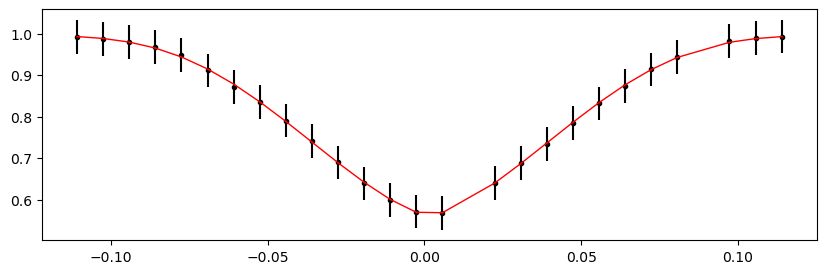

1717.9363625 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.62it/s]


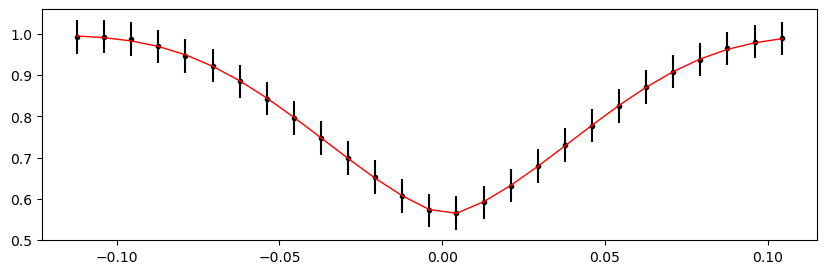

1720.4398375 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.31it/s]


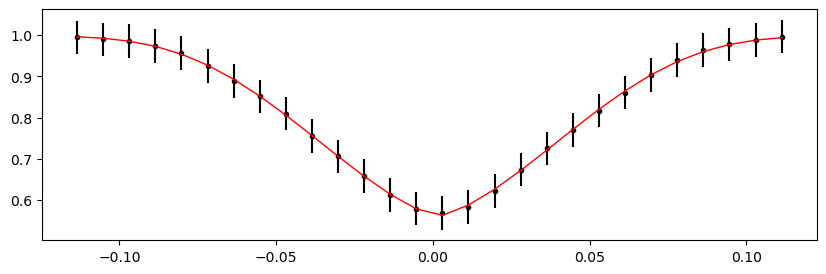

1722.9433125 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.62it/s]


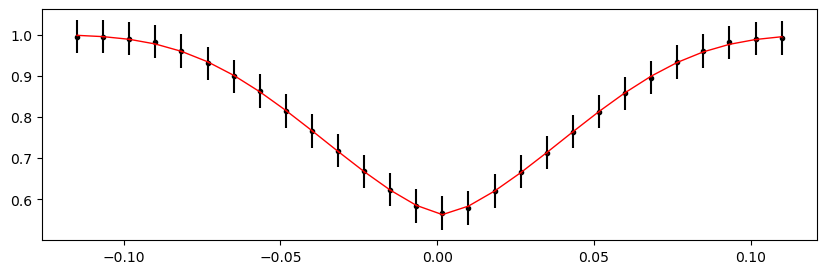

1725.4467875 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.87it/s]


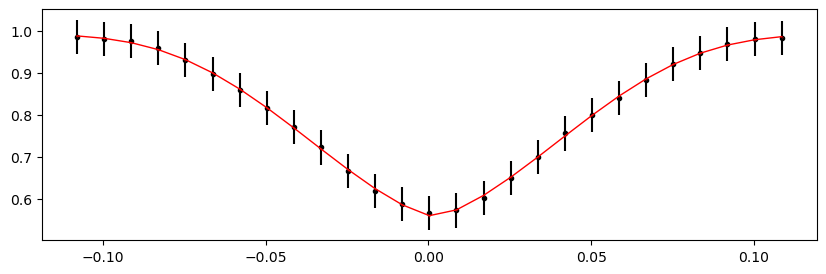

1727.9502625000002 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.96it/s]


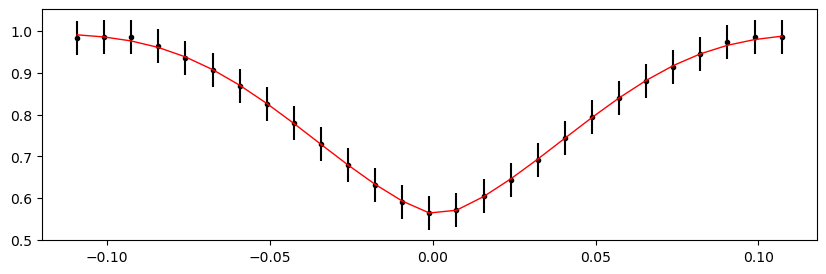

1730.4537375000002 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.96it/s]


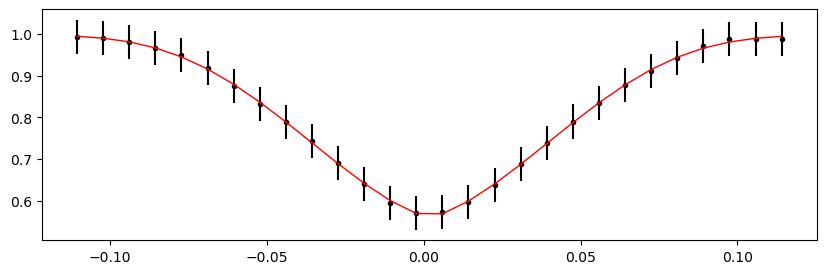

1732.9572125000002 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.19it/s]


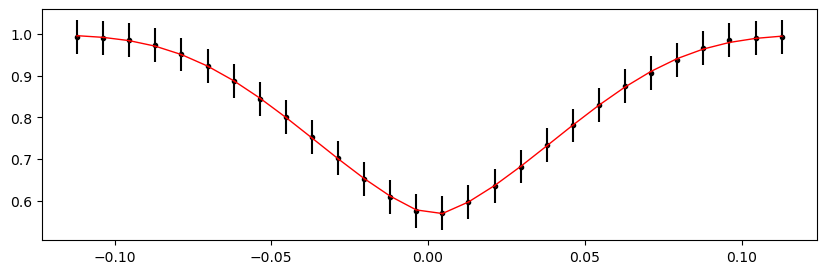

1735.4606875000002 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.30it/s]


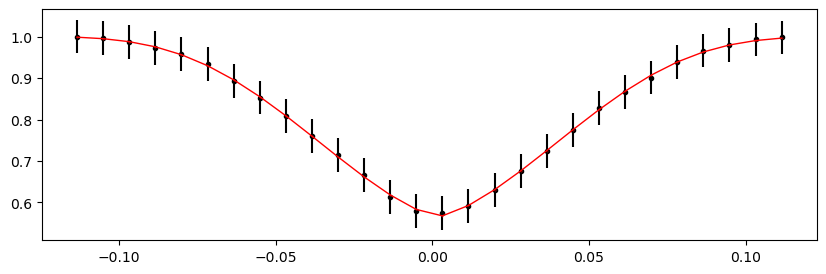

1740.4676375000001 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 248.85it/s]


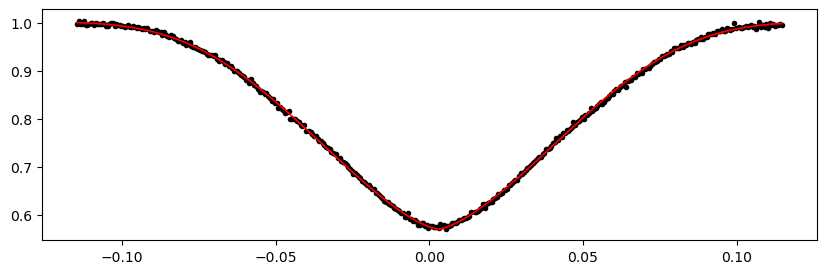

1742.9711125000001 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.12it/s]


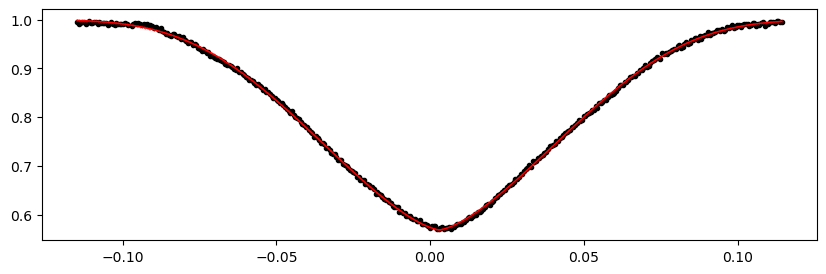

1745.4745875 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.88it/s]


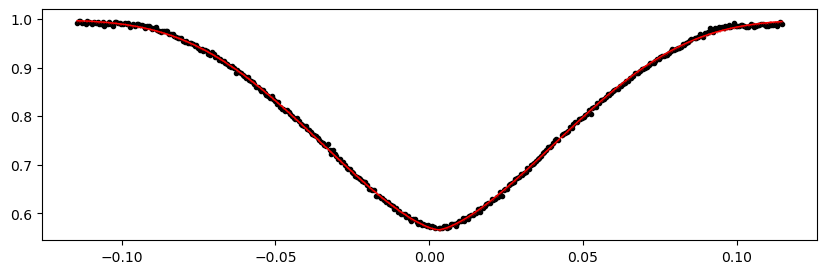

1747.9780625 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 259.84it/s]


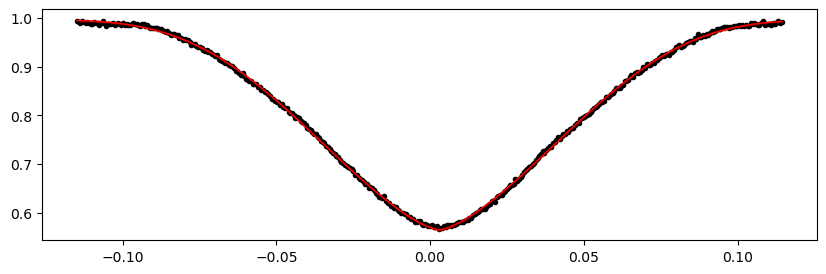

1752.9850125 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 262.32it/s]


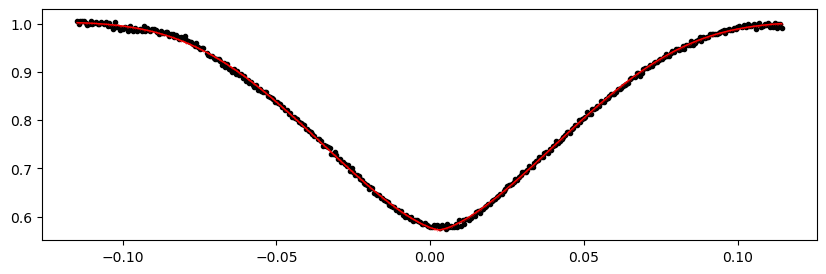

1755.4884875 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


100%|███████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 251.03it/s]


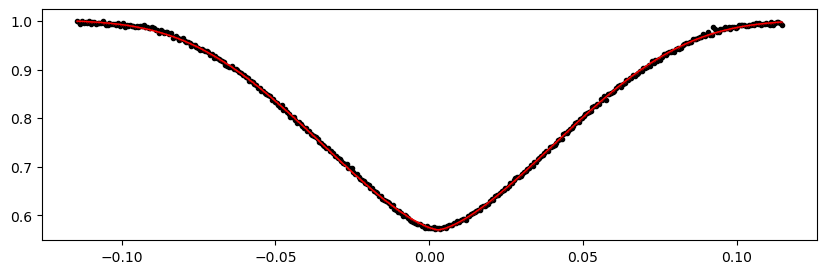

1757.9919625000002 0.9999842494068141 -0.4337979706742515 -0.27206447118966226


 98%|███████████████████████████████████████████████████████ | 9835/10000 [00:38<00:00, 258.75it/s]Traceback (most recent call last):
  File "C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\etv\etv_functions.py", line 533, in log_probability_fitting
    if not np.isfinite(lp):
KeyboardInterrupt
 98%|███████████████████████████████████████████████████████▏| 9848/10000 [00:39<00:00, 252.42it/s]


emcee: Exception while calling your likelihood function:
  params: [ 0.99943258 -0.43156413  0.00297534]
  args: (array([-1.14805752e-01, -1.14250970e-01, -1.13696188e-01, -1.13141406e-01,
       -1.12586624e-01, -1.12031842e-01, -1.11477060e-01, -1.10922278e-01,
       -1.10367496e-01, -1.09812714e-01, -1.09257932e-01, -1.08703150e-01,
       -1.08148368e-01, -1.07593586e-01, -1.07038804e-01, -1.06484022e-01,
       -1.05929240e-01, -1.05374458e-01, -1.04819676e-01, -1.04264894e-01,
       -1.03710112e-01, -1.03155330e-01, -1.02600548e-01, -1.02045766e-01,
       -1.01490984e-01, -1.00936202e-01, -1.00381420e-01, -9.98266376e-02,
       -9.92718556e-02, -9.87170736e-02, -9.81622916e-02, -9.76075095e-02,
       -9.70527274e-02, -9.64979454e-02, -9.59431634e-02, -9.53883814e-02,
       -9.48335994e-02, -9.42788174e-02, -9.37240353e-02, -9.31692533e-02,
       -9.26144713e-02, -9.20596893e-02, -9.15049073e-02, -9.09501253e-02,
       -9.03953432e-02, -8.98405611e-02, -8.92857791e-02, -8.

KeyboardInterrupt: 

## ETV O-C plot

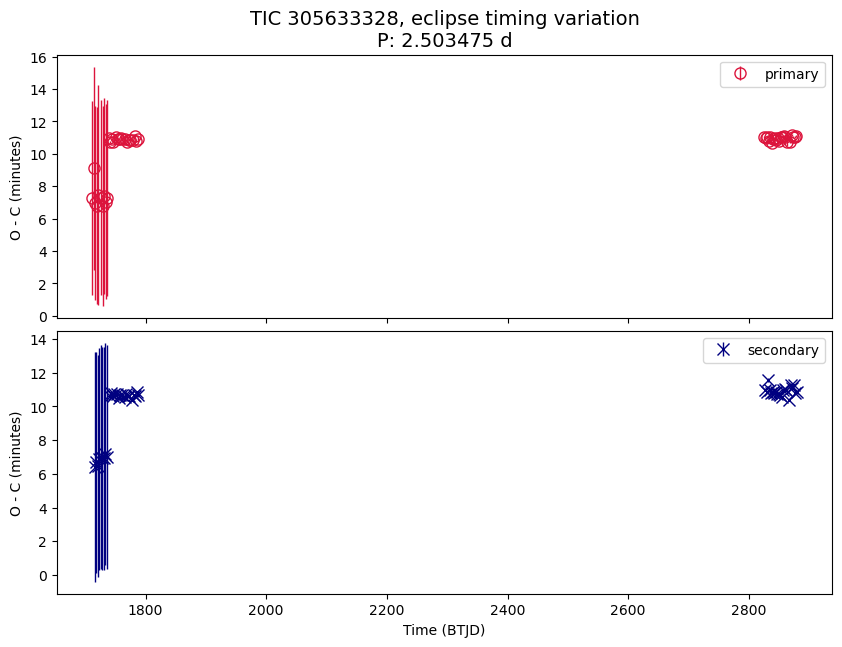

In [28]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

- abrupt jump in O-C around BTJD 1738 is related to switching from QLP lightcurve (sector 15, < BTJD 1738) to SPOC lightcurves (sector 16+)

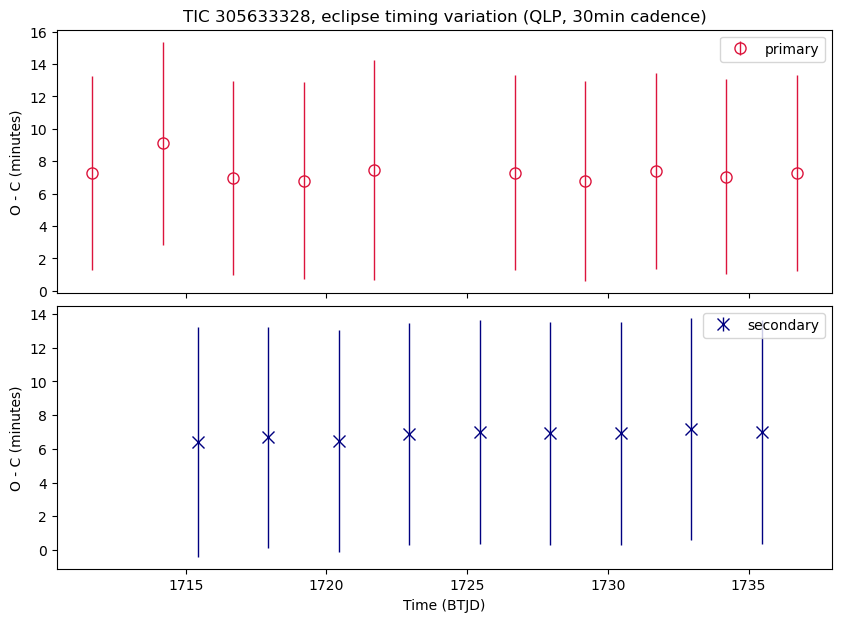

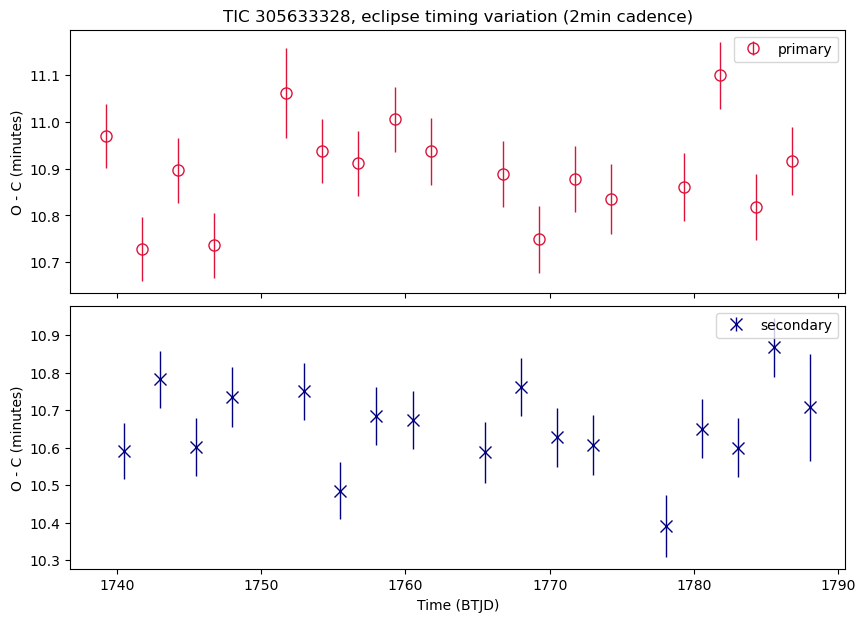

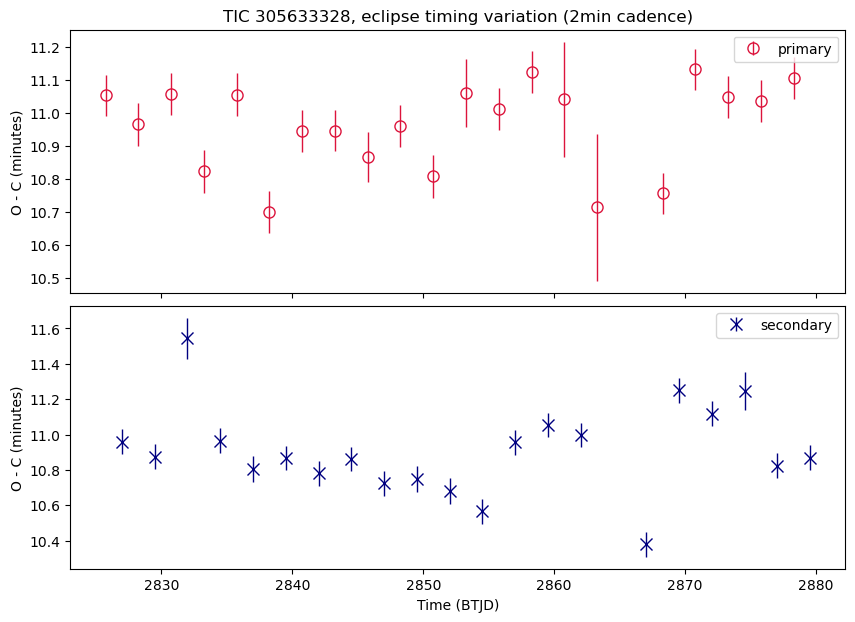

In [39]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1700, 1738),
    (1738, 1800),
    (2800, 3000),
]
title_suffix = "eclipse timing variation"

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[0][0]
    ax.set_title(f"{ax.get_title()} (QLP, 30min cadence)")
    for i in [1, 2]:
        ax = axs_list[i][0]
        ax.set_title(f"{ax.get_title()} (2min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

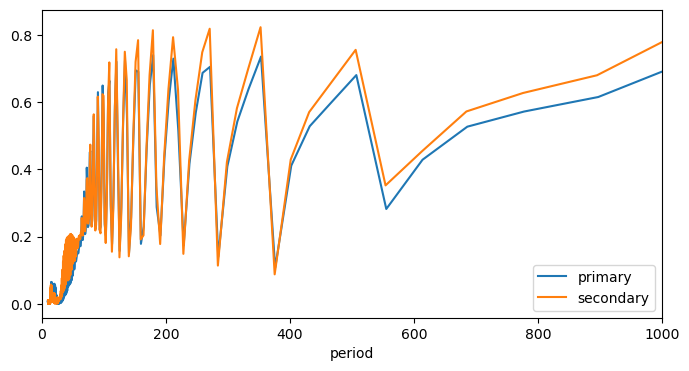

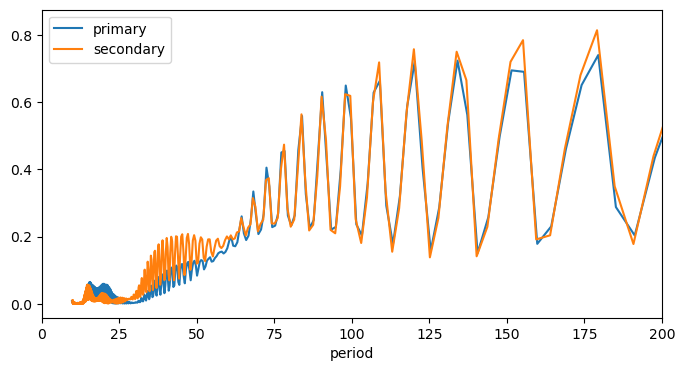

In [41]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 200)
    plt.show()

## Results Summary

In [43]:
# FILL-IN the ETV results / comments
has_etv = "N?"
comments = "O-C has small scatter (< 1 min amplitude), probably insignificant."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

,0
tic,305633328
has_etv,N?
comments,"O-C has small scatter (< 1 min amplitude), probably insignificant."
period,2.503475
depth_pct_p,47.35
depth_pct_s,43.38
epoch_p,1711.677675
epoch_s,1712.929413
num_sectors,5
time_span,1170.73



tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
305633328,N?,"O-C has small scatter (< 1 min amplitude), probably insignificant.",2.503475,47.35,43.38,1711.6776750000001,1712.9294125000001,5,1170.73,1711.38,2882.12

